### Abrir archivo features


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('./video_features-master/train_r21d_all_mean.csv') #cambiar la ruta a tu archivo

df_np = df.to_numpy()
X = df_np[:, :-2]
print("dimensiones: " , X.shape)
y = df_np[:, -2] #en este caso la ultima columna es el id del video y la penultima la etiqueta
print("dimensiones: " , y.shape)

#if getting labels from train_subset.csv is necessary
#train_subset = pd.read_csv('./video_features-master/train_subset.csv') #para sacar las etiquetas de los x primeras filas
#y = train_subset['label'].to_numpy()
#y = y[:df_np.shape[0]]
#print("etiquetas: " , y.shape)

dimensiones:  (2812, 514)
dimensiones:  (2812,)


De esos miles de features queremos capturar apenas los más relevantes, aplicamos librerias para reducir la dimensionalidad. Cuando aplicamos algoritmos de reducción queremos capturar la mayor varianza posible (ya que más varianza = más información), capturando los features más relevantes



### PCA

In [31]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Rango de componentes para probar (de 1 a 151 en pasos de 5)
n_components_range = range(1, 151, 5)

# Define the parameter grid
param_grid = {'n_components': n_components_range}
pca = PCA()

# Create the GridSearchCV object
grid_search = GridSearchCV(pca, param_grid, cv=5, scoring='explained_variance')

# Fit the data to the GridSearchCV object
grid_search.fit(X)

# The best number of components is in grid_search.best_params_
best_n_components = grid_search.best_params_['n_components']

# Now you can use the best number of components to transform your data
pca = PCA(n_components=best_n_components)
X_pca = pca.fit_transform(X)
print("Reduced dimensions shape: ", X_pca.shape)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\davie\VSCode_projects\Machine Learning\Proyecto3\venv\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "c:\Users\davie\VSCode_projects\Machine Learning\Proyecto3\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\davie\VSCode_projects\Machine Learning\Proyecto3\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\davie\VSCode_projects\Machine Learning\Proyecto3\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 370, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "c:\Users\davie\VSCode_projects\Machine Learning\Proyecto3\ve

Reduced dimensions shape:  (2812, 1)


c:\Users\davie\VSCode_projects\Machine Learning\Proyecto3\venv\lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to 0. Details: 
Traceback (most recent call last):
  File "c:\Users\davie\VSCode_projects\Machine Learning\Proyecto3\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\davie\VSCode_projects\Machine Learning\Proyecto3\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\davie\VSCode_projects\Machine Learning\Proyecto3\venv\lib\site-packages\sklearn\metrics\_scorer.py", line 370, in _score
    response_method = _check_response_method(estimator, self._response_method)
  File "c:\Users\davie\VSCode_projects\Machine Learning\Proyecto3\ve

In [32]:
print("Reduced dimensions shape: ", X_pca.shape)

Reduced dimensions shape:  (2812, 1)


In [34]:
def graph_components(n_components_range, dim_red_obj):
    explained_variance = []
    # Loop over the range of components and calculate the explained variance
    for n_components in n_components_range:
        dim_red_obj.set_params(n_components=n_components)
        dim_red_obj.fit(X)
        explained_variance.append(dim_red_obj.explained_variance_ratio_.sum())

    # Plot the explained variance
    plt.plot(n_components_range, explained_variance)
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance ratio')
    plt.title('Explained variance by number of components')
    plt.show()

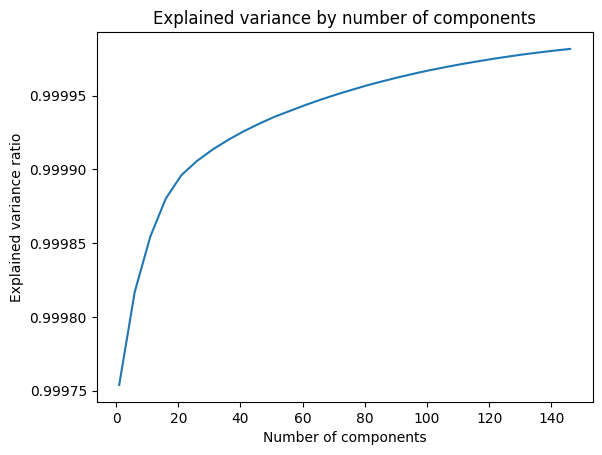

In [37]:
graph_components(n_components_range,pca)

### Truncated SVD

In [35]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np
np.random.seed(0)
#X_dense = np.random.rand(100, 100)
#X_dense[:, 2 * np.arange(50)] = 0
#X = csr_matrix(X_dense)
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42) #cambiar numero de componentes
X_svd =svd.fit_transform(X)
TruncatedSVD(n_components=5, n_iter=7, random_state=42)
print(svd.explained_variance_ratio_)
print(svd.explained_variance_ratio_.sum())
print(svd.singular_values_)

[9.99645662e-01 1.16152051e-04 1.67141607e-05 1.27887215e-05
 1.17892783e-05]
0.999803105837634
[86073.65585956   531.18771634   176.00623969   153.95722229
   147.81977187]


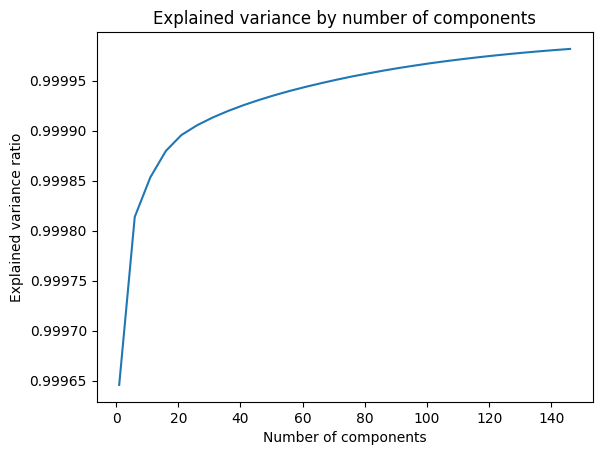

In [36]:
graph_components(n_components_range, svd)

In [10]:
cumulative_explained_variance = np.cumsum(svd.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_explained_variance >= 0.90) + 1

print(f'Optimal number of components: {optimal_components}')
print(cumulative_explained_variance)
print(X_svd.shape)

Optimal number of components: 1
[0.5602586  0.63902029 0.7158621  0.76627501 0.80871289]
(15, 5)


### LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
#y = np.array([1, 1, 1, 2, 2, 2])
clf = LinearDiscriminantAnalysis()
X_lda = clf.fit_transform(X, y)
LinearDiscriminantAnalysis()
print(clf.predict([[-0.8, -1]]))

### Gaussian Random projection


In [42]:
from sklearn import random_projection
gauss_rand = random_projection.GaussianRandomProjection(eps=.8)
X_gaussian = gauss_rand.fit_transform(X)
X_gaussian.shape

(2812, 212)

In [44]:
graph_components(n_components_range,X_gaussian)

AttributeError: 'numpy.ndarray' object has no attribute 'set_params'

### Factor Analysis

In [ ]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FactorAnalysis
X, _ = load_digits(return_X_y=True)
transformer = FactorAnalysis(n_components=7, random_state=0)
X_fa = transformer.fit_transform(X)
X_fa.shape

### Accuracy testing
Probando clustering con libreria solo para ver accuracy

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder

#transform labels from text to numeric values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply K-means clustering
n_clusters = len(np.unique(y_encoded))  # Set number of clusters to number of unique labels
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X_pca) #CAMBIAR ESTO POR EL X REDUCIDO QUE QUEREMOS PROBAR

# Map cluster labels to true labels
def map_labels(y_true, y_pred):
    labels = np.zeros_like(y_pred)
    for i in range(n_clusters):
        mask = (y_pred == i)
        if np.sum(mask) > 0:
            labels[mask] = mode(y_true[mask])[0]
    return labels

# Map predicted labels to true labels
y_kmeans_mapped = map_labels(y_encoded, y_kmeans)

# Calculate accuracy
accuracy = accuracy_score(y_encoded, y_kmeans_mapped)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.10
